# Goal

* Follow-up to `atomIncorp_taxaIncorp` simulation run.
* Investigating factors that influenced accuracy
  * e.g., pre-fractionation abundance or G+C of fragments

# Setting parameters

In [14]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/'
frag_info_file = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde_info.txt'

## Init

In [2]:
import os
import glob
import itertools
import nestly

In [3]:
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


### BD min/max

In [5]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Reading in all necessary files

# Comm files

In [6]:
F = os.path.join(workDir, '*', '*', '*', 'comm.txt')
files = glob.glob(F)
print len(files)

200


In [7]:
%%R -i files

df_comm = list()
for (f in files){
    df.tmp = read.delim(f, sep='\t')
    ff = strsplit(f, '/') %>% unlist
    df.tmp$percIncorp = ff[9]
    df.tmp$percTaxa = ff[10]
    df.tmp$sim_rep = ff[11]
    f_name = ff[12]
    df_comm[[f]] = df.tmp
}

df_comm = do.call(rbind, df_comm)
rownames(df_comm) = 1:nrow(df_comm)
df_comm %>% head(n=3)

  library                                         taxon_name rel_abund_perc
1       1               Stackebrandtia_nassauensis_DSM_44728       6.765330
2       1 Bifidobacterium_kashiwanohense_JCM_15439_DSM_21854       4.631052
3       1                        Staphylococcus_pasteuri_SP1       4.487604
  rank percIncorp percTaxa sim_rep
1    1         50       50       7
2    2         50       50       7
3    3         50       50       7


## Classification data

In [96]:
F = os.path.join(workDir, '*', '*', '*', '*_data.txt')
files = glob.glob(F)
print len(files)

800


In [97]:
%%R -i files

cols = c('library', 'taxon', 'min', 'q25', 'mean', 'median', 'q75', 'max', 'incorp.known', 'incorp.pred')

df_data = list()
for (f in files){
    df.tmp = read.delim(f, sep='\t')
    df.tmp = df.tmp[,cols]
    ff = strsplit(f, '/') %>% unlist
    df.tmp$percIncorp = ff[9]
    df.tmp$percTaxa = ff[10]
    df.tmp$sim_rep = ff[11]
    df.tmp$method = gsub('-cMtx_data.txt', '', ff[12])
    f_name = ff[12]
    df_data[[f]] = df.tmp
}

df_data = do.call(rbind, df_data)
rownames(df_data) = 1:nrow(df_data)
df_data %>% head(n=3)

  library                                taxon   min   q25  mean median   q75
1       2       Acaryochloris_marina_MBIC11017 0.018 0.018 0.018  0.018 0.018
2       2 Acetobacter_pasteurianus_IFO_3283-03 0.018 0.018 0.018  0.018 0.018
3       2       Acetobacterium_woodii_DSM_1030 0.000 0.000 0.000  0.000 0.000
    max incorp.known incorp.pred percIncorp percTaxa sim_rep method
1 0.018         TRUE          NA         50       50       7   qSIP
2 0.018         TRUE        TRUE         50       50       7   qSIP
3 0.000        FALSE       FALSE         50       50       7   qSIP


## Fragment GC & length info

In [98]:
%%R -i frag_info_file

df_info = read.delim(frag_info_file, sep='\t')
df_info %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID        min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1   1.706611     1.707293
2      1 Tropheryma_whipplei_str_Twist      2 764.000000  4083.900000
3      1   Caldisericum_exile_AZM16c01    NaN        NaN          NaN
  percentile_25        mean      median percentile_75 percentile_95
1       1.70821    1.709684    1.709798      1.710688      1.712764
2    6111.75000 7029.913200 7292.000000   8202.000000   9049.000000
3           NaN         NaN         NaN           NaN           NaN
           max        stdev
1     1.717466 1.643647e-03
2 10465.000000 1.536037e+03
3          NaN          NaN


# Formatting table

In [99]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [100]:
%%R
# comm & classificatino
join.on = c(
'library' = 'library',
'taxon_name' = 'taxon', 
'percIncorp' = 'percIncorp',
'percTaxa' = 'percTaxa',
'sim_rep' =  'sim_rep')

df.j = inner_join(df_comm, df_data, join.on) %>%
    filter(library %in% c(2,4,6)) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) 

# frag info
df.j = inner_join(df.j, df_info, c('taxon_name'='taxon_ID'))

df.j %>% head(n=3)

  library                           taxon_name rel_abund_perc rank percIncorp
1       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
2       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
3       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
  percTaxa sim_rep min.x q25 mean.x median.x q75 max.x incorp.known incorp.pred
1       50       7     0   0      0        0   0     0        FALSE       FALSE
2       50       7     0   0      0        0   0     0        FALSE       FALSE
3       50       7     0   0      0        0   0     0        FALSE       FALSE
  method           cls lib_ID KDE_ID      min.y percentile_5 percentile_25
1   qSIP True negative      1      1   1.713244     1.714739       1.71712
2   qSIP True negative      1      2 366.000000  4117.000000    6141.00000
3 DESeq2 True negative      1      1   1.713244     1.714739       1.71712
       mean.y    median.y percentile_75 percentile_95        max.y  

In [101]:
%%R
# renaming method
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'HR-SIP_multi', 'Heavy-SIP', 'qSIP'))

df.j = inner_join(df.j, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

# reorder
as.Num = function(x) x %>% as.character %>% as.numeric
df.j$percTaxa = reorder(df.j$percTaxa, df.j$percTaxa %>% as.Num)
df.j$percIncorp = reorder(df.j$percIncorp, df.j$percIncorp %>% as.Num)
    
df.j %>% head(n=3)    

  library                           taxon_name rel_abund_perc rank percIncorp
1       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
2       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
3       2 Stackebrandtia_nassauensis_DSM_44728       4.849462    1         50
  percTaxa sim_rep min.x q25 mean.x median.x q75 max.x incorp.known incorp.pred
1       50       7     0   0      0        0   0     0        FALSE       FALSE
2       50       7     0   0      0        0   0     0        FALSE       FALSE
3       50       7     0   0      0        0   0     0        FALSE       FALSE
            cls lib_ID KDE_ID      min.y percentile_5 percentile_25      mean.y
1 True negative      1      1   1.713244     1.714739       1.71712    1.719523
2 True negative      1      2 366.000000  4117.000000    6141.00000 7048.046300
3 True negative      1      1   1.713244     1.714739       1.71712    1.719523
     median.y percentile_75 percentile_95       

## accuracy ~ abundance

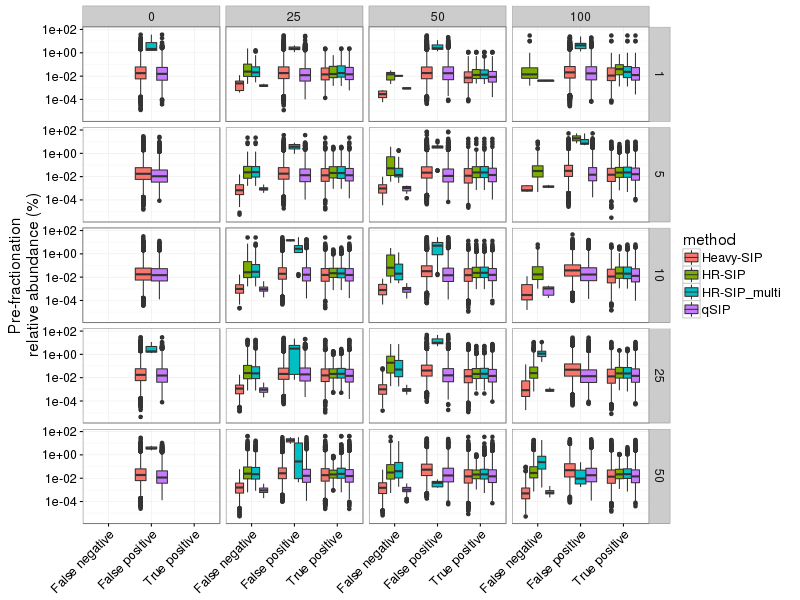

In [102]:
%%R -w 800 -h 600
df.j.f = df.j %>%
    filter(KDE_ID == 1, 
           cls != 'True negative') 

ggplot(df.j.f, aes(cls, rel_abund_perc, fill=method)) +
    geom_boxplot() +
    facet_grid(percTaxa ~ percIncorp) +
    scale_y_log10() +
    labs(y='Pre-fractionation\nrelative abundance (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

## accuracy ~ fragment BD

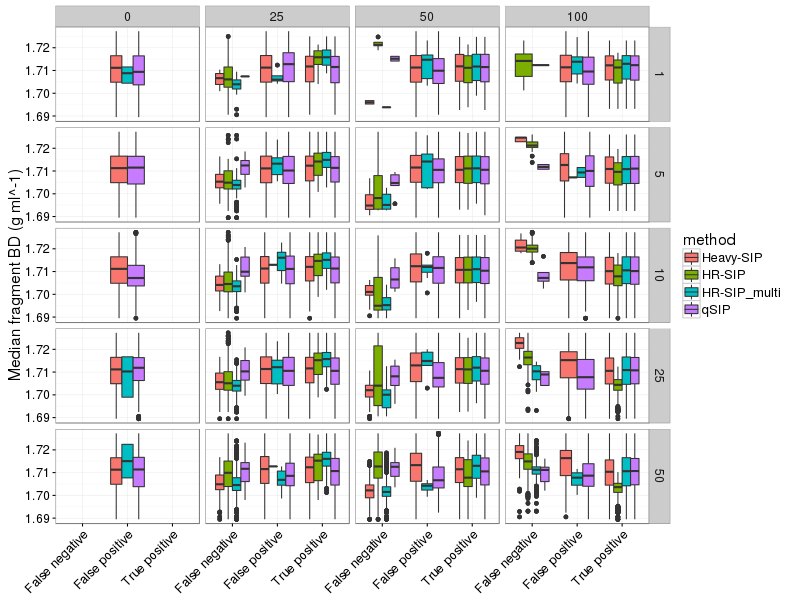

In [103]:
%%R -w 800 -h 600

ggplot(df.j.f, aes(cls, median.y, fill=method)) +
    geom_boxplot() +
    facet_grid(percTaxa ~ percIncorp) +
    labs(y='Median fragment BD (g ml^-1)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

### Converting to GC

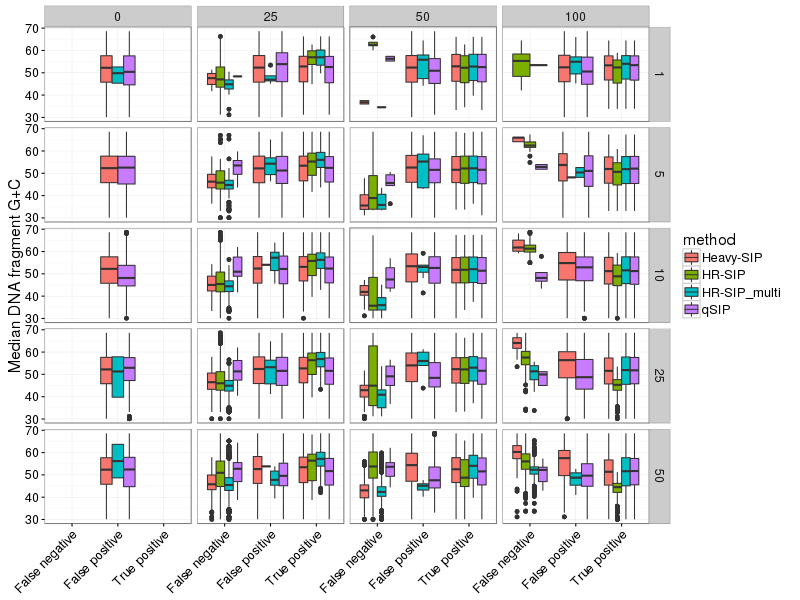

In [104]:
%%R -w 800 -h 600
BD2GC = function(p){
    (p - 1.66) / 0.098 * 100
}

df.j.f = df.j.f %>%
    mutate(median_GC = sapply(median.y, BD2GC))


ggplot(df.j.f, aes(cls, median_GC, fill=method)) +
    geom_boxplot() +
    facet_grid(percTaxa ~ percIncorp) +
    labs(y='Median DNA fragment G+C') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

In [105]:
%pushnote atomIncorp_taxaIncorp_acc-factors complete